<img src='https://imgur.com/JsHyyRl.png'>
ref: https://imgur.com/JsHyyRl

   <center> <h1> Airbnb New User Bookings </h1></center>

## Problem statement :
Airbnb is an online marketplace and hospitality service, enabling people to lease or rent short-term lodging including vacation rentals, apartment rentals, homestays, hostels beds, or hotel rooms. New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand. We need to predict the first travel destination of a new user based on his personalized content.


## Data Overview:
* **Train_users.csv -** There are 16 features used to describe each user in the dataset:
    * id: user id
    * date_account_created: the date of account creation
    * timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_creat date_first_booking 
    * date_first_booking: date of first booking
    * gender
    * age
    * signup_method
    * signup_flow: the page a user came to signup up from
    * language: international language preference
    * affiliate_channel: what kind of paid marketing
    * affiliate_provider: where the marketing is e.g. google, craigslist, other
    * first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    * signup_app
    * first_device_type
    * first_browser
    * country_destination: this is the target variable you are to predict
    
* **Sessions.csv -** web sessions log for users
    * user_id: to be joined with the column 'id' in users table
    * action
    * action_type
    * action_detail
    * device_type
    * secs_elapsed

* **Countries.csv -** summary statistics of destination countries in this dataset and their locations

* **Age_gender_bkts.csv -** summary statistics of users' age group, gender, country of destination

## Objective:

 * Predict top **5 travel destinations** in decreasing order of relevance
 
## Performance metrics:

 * The Performance metric used for this Project is **NDCG (Normalized discounted cumulative gain)**

## Reference links:
* https://en.wikipedia.org/wiki/Airbnb
* https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview
* https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview/evaluation

## Exploratory Data Analysis

### Import all required Modules

In [1]:
# import all required modules
import pandas as pd
import numpy as np
import missingno as ms
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

### Reading data CSV

In [2]:
# read Train data from csv file
train=pd.read_csv("train_users.csv")
print("Train shape:",train.shape)
print("\nColumns:",train.columns)

# replace all -unknown- by Nan
train.gender.replace('-unknown-',np.nan, inplace=True)
train.age.replace('NaN', np.nan, inplace=True)
train.head(6)

Train shape: (213451, 16)

Columns: Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,NaN,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US


In [3]:
# read sessions data from csv file
session=pd.read_csv("sessions.csv")
print("Session_Data shape:",session.shape)
print("\nColumns:",session.columns)
session.head(6)

Session_Data shape: (10567737, 6)

Columns: Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0


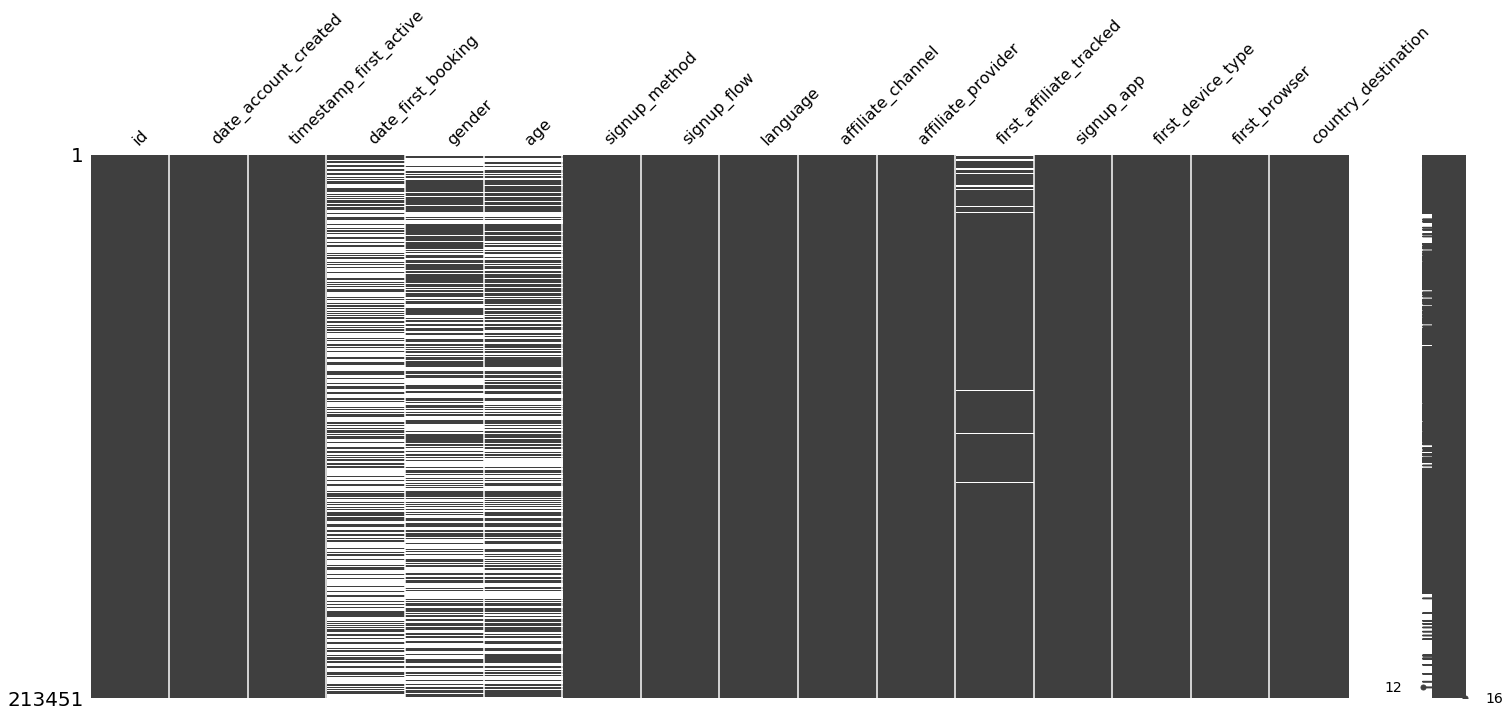

In [0]:
#https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/
# Train missing data plot
ms.matrix(train)

* Missingno plot for Train Data show that there is a **lot of missing** values in gender, age.

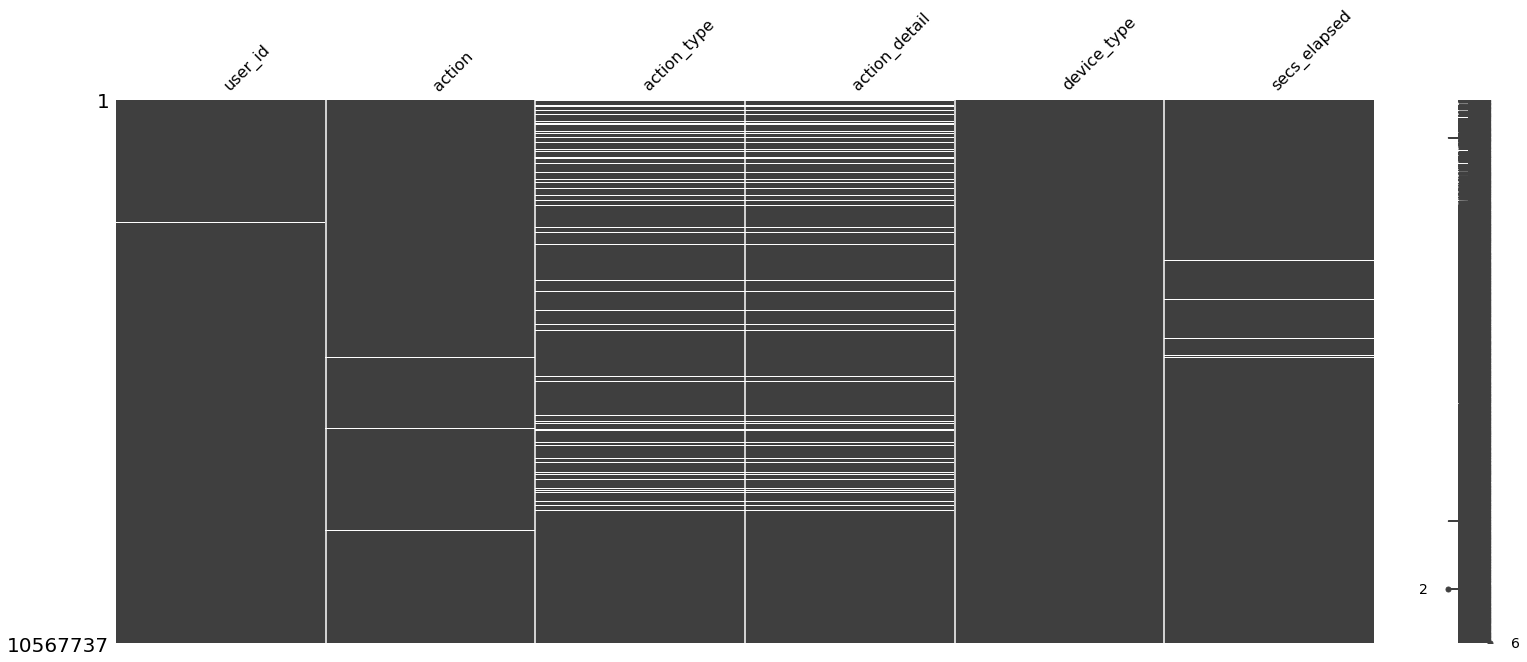

In [0]:
# Session missing data plot
ms.matrix(session)

* Missingno plot for Session Data show that there is **few missing value** in the data when compared to Train data

In [0]:
# Join train and session to find  no of users with log information
left=train.drop_duplicates(subset='id', keep='first')
right = session.drop_duplicates(subset='user_id', keep='first')
merge_id=left.merge(right, left_on='id', right_on='user_id', how='inner')

# print info
print("Train  :",left.shape)
print("Session:",right.shape)
print("Merge  :",merge_id.shape)
print("----"*14)
print("No of users in Train Data with Session Information:",merge_id.shape[0])
print("{} / {} = {}".format(merge_id.shape[0],left.shape[0],np.round((merge_id.shape[0]/left.shape[0]),2)))
print("----"*14)

Train  : (213451, 16)
Session: (135484, 6)
Merge  : (73815, 22)
--------------------------------------------------------
No of users in Train Data with Session Information: 73815
73815 / 213451 = 0.35
--------------------------------------------------------


* Only **35 %** of Users in Train Data contain **Session_log** Infomation

# Univariate analysis

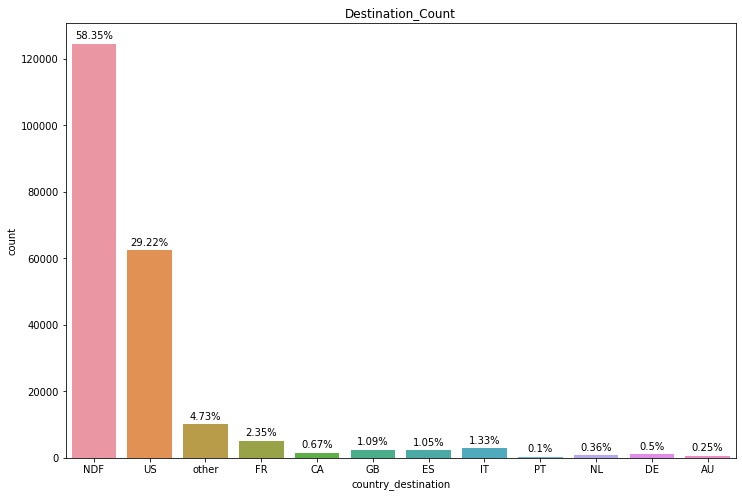

-----------------
 Percentage_Count
-----------------
NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64


In [4]:
# ref: https://seaborn.pydata.org/generated/seaborn.countplot.html
# Country_destination feature analysis
plt.figure(figsize=(12,8))
count=sns.countplot(train["country_destination"])
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.title("Destination_Count")
plt.show()
print("-----------------")
print(" Percentage_Count")
print("-----------------")
print(train.country_destination.value_counts() / train.shape[0] * 100)

* The Dataset is slightly **Imbalanced**.
* **57%** of users did not travel anywhere and **28%** users travelled inside **US**.

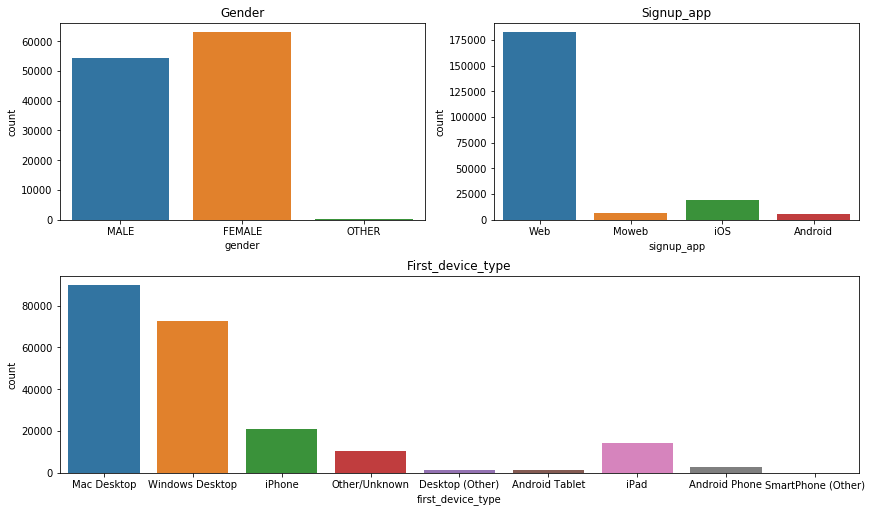

-----------------
Gender_Percentage_Count
-----------------
FEMALE    29.534179
MALE      25.504683
OTHER      0.132115
Name: gender, dtype: float64

------------------------------
signup_app_Percentage_Count
------------------------------
Web        85.601379
iOS         8.910242
Moweb       2.933226
Android     2.555153
Name: signup_app, dtype: float64

----------------------------------
First_device_type_Percentage_Count
----------------------------------
Mac Desktop           41.976847
Windows Desktop       34.066835
iPhone                 9.725417
iPad                   6.717701
Other/Unknown          4.997400
Android Phone          1.313182
Android Tablet         0.605291
Desktop (Other)        0.561721
SmartPhone (Other)     0.035605
Name: first_device_type, dtype: float64


In [4]:
# ref: https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html
import matplotlib.gridspec as gridspec

# Gender feature analysis
fig1 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig1.add_gridspec(4, 4)
f1_ax1 = fig1.add_subplot(gs[0:2,0:2])
sns.countplot(train["gender"],)
plt.title("Gender")

# signup_app feature analysis
f1_ax2 = fig1.add_subplot(gs[0:2, 2:])
sns.countplot(train["signup_app"])
plt.title("Signup_app")


# first_device_type feature analysis
f1_ax3 = fig1.add_subplot(gs[2:, 0:])
sns.countplot(train["first_device_type"])
plt.title("First_device_type")
plt.show()

print("-----------------")
print("Gender_Percentage_Count")
print("-----------------")
print(train.gender.value_counts() / train.shape[0] * 100)

print("\n------------------------------")
print("signup_app_Percentage_Count")
print("------------------------------")
print((train.signup_app.value_counts() / train.shape[0] * 100).head(5))

print("\n----------------------------------")
print("First_device_type_Percentage_Count")
print("----------------------------------")
print(train.first_device_type.value_counts() / train.shape[0] * 100)

* There is more number of **Female** users than Male users and the gender **info is unknown** for **45%** of the users.
* Majority of users use **Desktop** as First_device for booking.
* Users are prone to use **Web** as signup app.

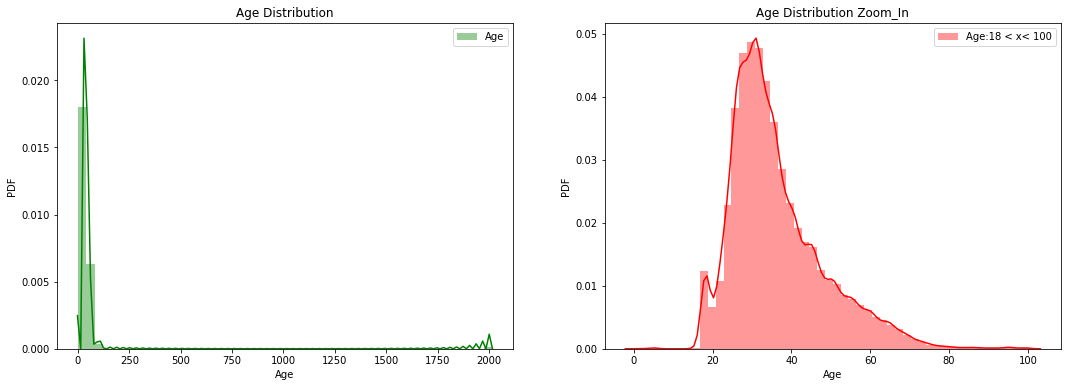

In [5]:
# ref: https://seaborn.pydata.org/generated/seaborn.distplot.html
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# subplot figure
f, axes = plt.subplots(1, 2, figsize=(18, 6))

# Age distribution
sns.distplot(train.age.dropna(),color="g", ax=axes[0],label="Age")
axes[0].set_title('Age Distribution')
axes[0].set(xlabel='Age', ylabel='PDF')
axes[0].legend()

# Age distribution zoom_in (18 < Age< 100)
train['age']=train['age'].apply(lambda x : 18 if x>100 else x)
sns.distplot(train.age.dropna(), color="r", ax=axes[1],label="Age:18 < x< 100")
axes[1].set_title('Age Distribution Zoom_In')
axes[1].set(xlabel='Age', ylabel='PDF')
axes[1].legend()
plt.show()

* The Distribution is **Right Skewed** and has large **Spread** for Age feature 
* The Age for majority of users is **between** **25** and **40** years.

In [0]:
# ref: https://www.geeksforgeeks.org/numpy-percentile-in-python/
# Obtaining secs_elasped and sort to compute percentile
sec_percentile =session["secs_elapsed"].values
sec_percentile = np.sort(sec_percentile,axis = None)

#computing secs_elasped values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
print("-"*28)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,sec_percentile[int(len(sec_percentile)*(float(i)/100))]))
print("100 percentile value is ",sec_percentile[-1])
print("-"*30)

#computing secs_elasped values at each percntile 90,91,92,93,94,95,96,97,98,99,100
print("-"*30)
for i in range(90,100):
    print("{} percentile value is {}".format(i,sec_percentile[int(len(sec_percentile)*(float(i)/100))]))
print("100 percentile value is ",sec_percentile[-1])
print("-"*30)

#computing secs_elasped values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
print("-"*28)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,sec_percentile[int(len(sec_percentile)*(float(99+i)/100))]))
print("100 percentile value is ",sec_percentile[-1])
print("-"*28)

----------------------------
0 percentile value is 0.0
10 percentile value is 52.0
20 percentile value is 144.0
30 percentile value is 383.0
40 percentile value is 712.0
50 percentile value is 1188.0
60 percentile value is 2342.0
70 percentile value is 5770.0
80 percentile value is 14510.0
90 percentile value is 39789.0
100 percentile value is  nan
------------------------------
------------------------------
90 percentile value is 39789.0
91 percentile value is 45479.0
92 percentile value is 52703.0
93 percentile value is 62191.0
94 percentile value is 75591.0
95 percentile value is 95600.0
96 percentile value is 129705.0
97 percentile value is 202165.0
98 percentile value is 457827.0
99 percentile value is nan
100 percentile value is  nan
------------------------------
----------------------------
99.0 percentile value is nan
99.1 percentile value is nan
99.2 percentile value is nan
99.3 percentile value is nan
99.4 percentile value is nan
99.5 percentile value is nan
99.6 percentile

* Only One Percentage of Data for secs_elasped Feature contain **Nan** values
* very **Few** percent of secs_elasped features has a **very large** values

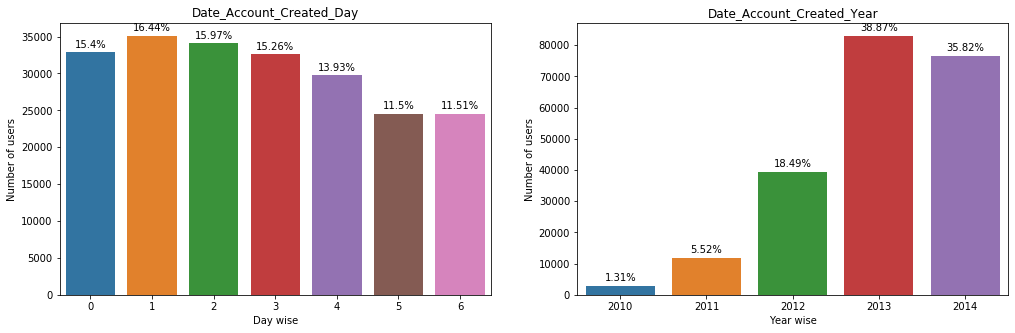

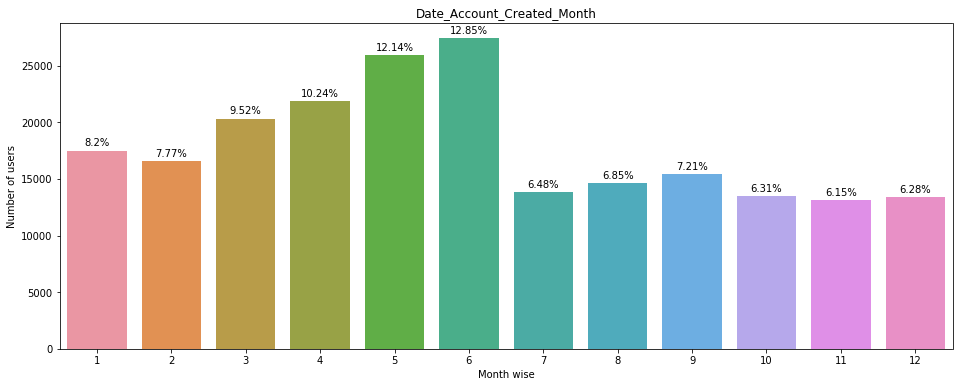

In [13]:
# ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
# obtaining info of year, month and day by Converting Str to date-time.
time_stamp=pd.DataFrame()
time_stamp['date_account_created_new'] = pd.to_datetime(train['date_account_created'])
time_stamp['date_account_created_day'] = time_stamp.date_account_created_new.dt.weekday
time_stamp['date_account_created_month'] = time_stamp.date_account_created_new.dt.month
time_stamp['date_account_created_year'] = time_stamp.date_account_created_new.dt.year

# Date_account_created analysis by weekday
plt.figure(1,figsize=(17, 5))               
plt.subplot(121)
sns.set_palette("tab10")
count=sns.countplot(x='date_account_created_day',data=time_stamp)
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.xlabel('Day wise')
plt.ylabel('Number of users')
plt.title("Date_Account_Created_Day")

# Date_account_created analysis by year
plt.subplot(122)            
count=sns.countplot(x='date_account_created_year',data=time_stamp)
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.xlabel('Year wise')
plt.ylabel('Number of users')
plt.title("Date_Account_Created_Year")


# Date_account_created analysis by month
plt.figure(2,figsize=(16, 6))
plt.subplot(111)                
count=sns.countplot(x='date_account_created_month',data=time_stamp)
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.xlabel('Month wise')
plt.ylabel('Number of users')
plt.title("Date_Account_Created_Month")
plt.show()

* The lowest amount of account created weekday is on **saturday, sunday** and with **June** being highest account created month  
* The **Amount of users** grows Linearly for each year.

In [0]:
def func_per_count(lst, uni_stat):
    """
    Function to print Univariate statistics of Data
    
    parameters
    ----------
    lst <list>      : Data Columns
    uni_stat<list>  : Count values
    
    returns         : None  
    
    """
    for i in range(len(lst)):
        print("-"*len("|  {}_Percentage_Count  |".format(lst[i])))
        print("|  {}_Percentage_Count  |".format(lst[i]))
        print("-"*len("|  {}_Percentage_Count  |".format(lst[i])))
        print(uni_stat[i])
        print("\t"*len("|  {}_Percentage_Count  |".format(lst[i])))

In [0]:
# Train_Data Univariate feature Percentage_Count anlysis  
print("Train_Data Univariate feature Percentage_Count anlysis:")
lst=['signup_method','first_browser','affiliate_channel','affiliate_provider','first_affiliate_tracked','language']

uni_stat=[]
for i in lst:
    uni_stat.append((train[i].value_counts() / train.shape[0] * 100).head(4))
func_per_count(lst,uni_stat)

Train_Data Univariate feature Percentage_Count anlysis:
------------------------------------
|  signup_method_Percentage_Count  |
------------------------------------
basic       71.630960
facebook    28.113244
google       0.255796
Name: signup_method, dtype: float64
																																				
------------------------------------
|  first_browser_Percentage_Count  |
------------------------------------
Chrome       29.910846
Safari       21.161297
Firefox      15.767085
-unknown-    12.773892
Name: first_browser, dtype: float64
																																				
----------------------------------------
|  affiliate_channel_Percentage_Count  |
----------------------------------------
direct           64.523942
sem-brand        12.201864
sem-non-brand     8.828256
other             4.198153
Name: affiliate_channel, dtype: float64
																																								
-----------------------------------------
|  affiliate_provider_Percentage_Count  |
----------------------

In [0]:
# Session_Data Univariate feature Percentage_Count anlysis  
print("Session_Data Univariate feature Percentage_Count anlysis:")
lst=['action','action_type','action_detail','device_type']

uni_stat=[]
for i in lst:
    uni_stat.append((session[i].value_counts() / session.shape[0] * 100).head(5))
func_per_count(lst,uni_stat)

Session_Data Univariate feature Percentage_Count anlysis:
-----------------------------
|  action_Percentage_Count  |
-----------------------------
show              26.195561
index              7.983724
search_results     6.862642
personalize        6.688509
search             5.072581
Name: action, dtype: float64
																													
----------------------------------
|  action_type_Percentage_Count  |
----------------------------------
view         33.695975
data         19.907479
click        18.889408
-unknown-     9.757718
submit        5.898680
Name: action_type, dtype: float64
																																		
------------------------------------
|  action_detail_Percentage_Count  |
------------------------------------
view_search_results        16.814243
p3                         13.025968
-unknown-                   9.757444
wishlist_content_update     6.688509
user_profile                6.215512
Name: action_detail, dtype: float64
																																

**Univariate observation:**
* Users are not that much conserned to perform any Action on there **user Profile**.
* Almost 60% of users use Desktop on Airbnb after **creating the account**.
* Large amount of users use **Web** for Signup with **Basic** as signup method.
* Almost all users choose to have **English** as there **primary language**.
* Only a small chunck of users end up on airbnb from different **affiliate_provider**

# Bivariate analysis

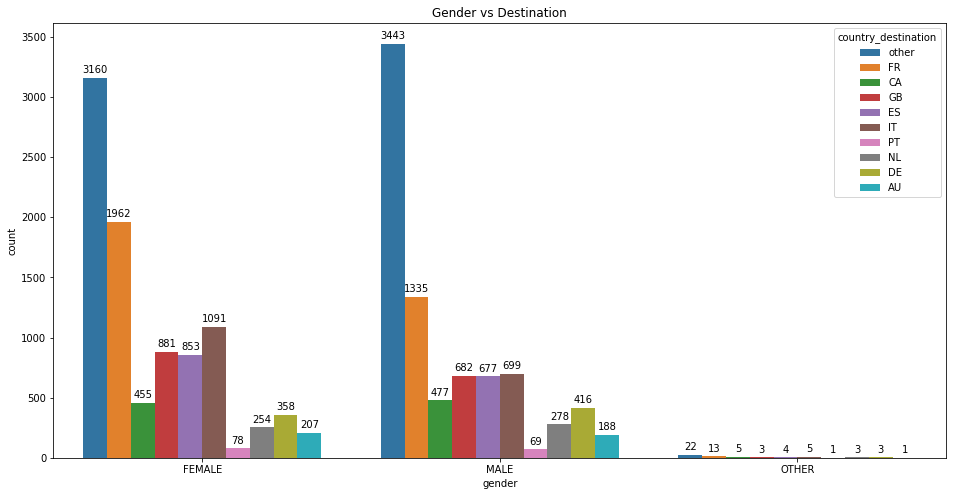

In [5]:
# ref: https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.annotate.html

# Get only Non-US and Non_Ndf for Bivaraite Analysis
no_us_ndf=train[(train['country_destination']!='US') & (train['country_destination']!='NDF') ]

# Bivariate analysis on country_destination by gender Feature
plt.figure(figsize=(16,8))
sns.set_palette("tab10")
count=sns.countplot(x='gender', hue="country_destination",data=no_us_ndf)
for patch in count.patches:
    count.annotate(format(patch.get_height()), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.title("Gender vs Destination")
plt.show()

* More number of **Male** users travel to **"other"** Country Destination  when compared to different destinations.
* More number of **Female** users travel to Country Destination **"FR"** when compared to different destinations.

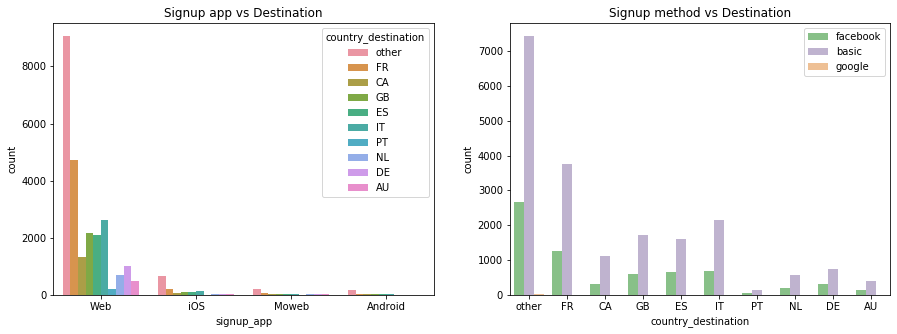

In [0]:
# Bivariate analysis on country_destination by signup_app Feature
plt.figure(1,figsize=(15, 5))    
sns.set_palette("Accent")
plt.subplot(121)
sns.countplot(x='signup_app', hue="country_destination",data=no_us_ndf)
plt.title("Signup app vs Destination")

# Bivariate analysis on country_destination by signup_method Feature
plt.subplot(122)  
sns.countplot(x='country_destination', hue="signup_method",data=no_us_ndf)
plt.title("Signup method vs Destination")
plt.legend(loc=1)
plt.show()

* There is almost **negligible** amount of signup happening by **google** compared to facebook, basic.
* There is very **less amount** of users who use **Android** compared to web,ios,Moweb.

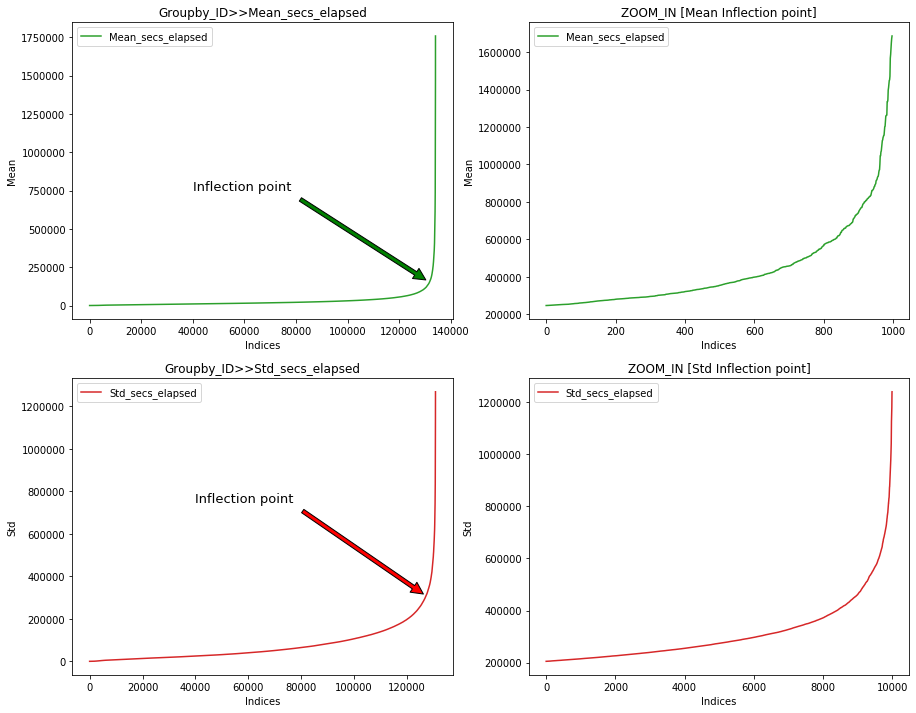

In [49]:
# ref: https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.subplots.html
# ref: https://matplotlib.org/3.1.1/tutorials/text/annotations.html

# Group_by id to obtain mean time elasped for each user
secs=session.groupby(['user_id']).mean()["secs_elapsed"].values
secs.sort()
secs = secs[np.logical_not(np.isnan(secs))]

# Group_by id to obtain std of time elasped for each user
std=session.groupby(['user_id']).std()["secs_elapsed"].values
std.sort()
std = std[np.logical_not(np.isnan(std))]

# plot subplot
figure, loc_ind = plt.subplots(2, 2,figsize=(15,12))

# Mean_secs_elapsed distribution
loc_ind[0, 0].plot(secs,'tab:green',label="Mean_secs_elapsed")
loc_ind[0, 0].set_title('Groupby_ID>>Mean_secs_elapsed')
loc_ind[0, 0].set(xlabel='Indices', ylabel='Mean')
loc_ind[0, 0].annotate('Inflection point', xy=(133059, 137258), xytext=(40000, 750000),
                            arrowprops=dict(facecolor='green', shrink=0.05),size=13)
loc_ind[0, 0].legend()

# # Mean_secs_elapsed at inflection point
loc_ind[0, 1].plot(secs[-1000:-2], 'tab:green',label="Mean_secs_elapsed")
loc_ind[0, 1].set_title('ZOOM_IN [Mean Inflection point]')
loc_ind[0, 1].set(xlabel='Indices', ylabel='Mean')
loc_ind[0, 1].legend()

# std of secs_elapsed distribution
loc_ind[1, 0].plot(std, 'tab:red',label="Std_secs_elapsed")
loc_ind[1, 0].set_title('Groupby_ID>>Std_secs_elapsed')
loc_ind[1, 0].set(xlabel='Indices', ylabel='Std')
loc_ind[1, 0].annotate('Inflection point', xy=(128798, 294606), xytext=(40000, 750000),
                        arrowprops=dict(facecolor='red', shrink=0.05),size=13)
loc_ind[1, 0].legend()

# std of secs_elapsed at inflection point
loc_ind[1, 1].plot(std[-10000:-2], 'tab:red',label="Std_secs_elapsed")
loc_ind[1, 1].set_title('ZOOM_IN [Std Inflection point]')
loc_ind[1, 1].set(xlabel='Indices', ylabel='Std')
loc_ind[1, 1].legend()
plt.show()

* The **Inflection point** of **Meantime spend** from a user is at the last 1000 users when time sorted in ascending order.  

* The Inflection point for **Std_devation** of time spend from a user is at the last 10000 users when time sorted in ascending order.

* The Mean and Std_devation of seconds that the user spends **varies a lot** with a large spread.

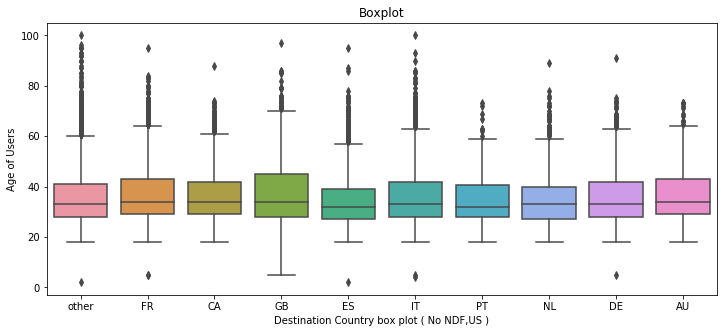

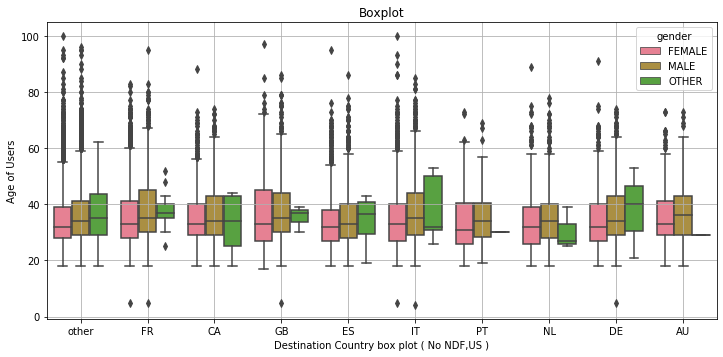

In [0]:
# ref: https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Box_plot analysis on country_destination by Age Feature
plt.figure(1,figsize=(12, 5))  
plt.subplot(111)            
sns.boxplot(y='age' , x='country_destination',data=no_us_ndf)
sns.set_palette("husl")
plt.xlabel('Destination Country box plot ( No NDF,US )')
plt.ylabel('Age of Users')
plt.title("Boxplot")
plt.show()

# Box_plot analysis on country_destination by Age Feature with gender
plt.figure(2,figsize=(12, 12))               
plt.subplot(211)            
sns.boxplot(y='age' , x='country_destination',hue="gender",data=no_us_ndf)
plt.xlabel('Destination Country box plot ( No NDF,US )')
plt.ylabel('Age of Users')
plt.title("Boxplot")
plt.grid()
plt.show()

**Bivariate Observations:**
* More **Older** users travel to Country Destination **"Great Britian"** than any other destinations.
* More **Younger** users travel to Country Destination **"Spain"** than any other destinations.
* There is almost no users with gender Others from **Australia** when compared to other destinations.
* Need to perform Multivate analysis to further **Explore Data**

# Multivariate analysis 


Performing Tsne with Perplexity 50 and with 1000 iterations at max


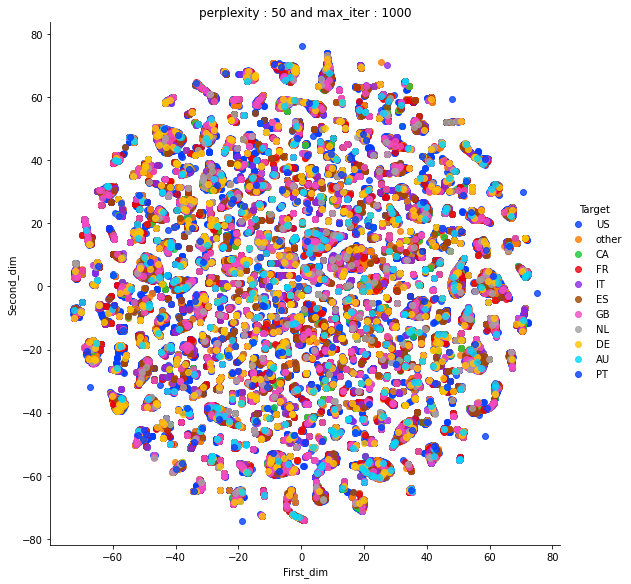

In [0]:
# T-sne Visualiztion 
from sklearn.manifold import TSNE # ref: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Data preparation for T-sne Visualiztion
Data=pd.read_csv("/content/drive/My Drive/Colab Notebooks/airbnb/best_folder/train_users.csv")
Data.gender.replace('-unknown-',np.nan, inplace=True)
Data.age.replace('NaN', np.nan, inplace=True)
Data.dropna(inplace=True)
Targets=Data["country_destination"]
Data.drop(['id','date_account_created','date_first_booking',"country_destination"],axis=1,inplace=True)

#encoding labels
col=['gender','signup_method','language','affiliate_channel','affiliate_provider','first_affiliate_tracked',
 'signup_app','first_device_type','first_browser']
for i in col:
    le = preprocessing.LabelEncoder()
    Data[i]=le.fit_transform(Data[i])
    
# normalization 
scaler = StandardScaler()
Data=scaler.fit_transform(Data)

# T-sne Function
def Tsne_visualization(X, Y, perplexities, itr, img_name_prefix='t-sne'):
        
    for index,perplexity in enumerate(perplexities):
        
        # Perform t-sne
        print('\nPerforming Tsne with Perplexity {} and with {} iterations at max'.format(perplexity, itr))
        X_Tsne = TSNE(verbose=0, perplexity=perplexity, n_iter=itr).fit_transform(X)
        
        # prepare the data result visualization        
        Tsne_Frame = pd.DataFrame({'First_dim':X_Tsne[:,0], 'Second_dim':X_Tsne[:,1] ,'Target':Y})
        
        # plot lm_scatter plot for visualization
        sns.lmplot(data=Tsne_Frame, x='First_dim', y='Second_dim', hue='Target', fit_reg=False, size=8, palette="bright")
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, itr))
        plt.show()

# function_call        
Tsne_visualization(X = Data, Y=Targets, perplexities =[50], itr=1000)

* There is no clear seperation between Country destinations and the points overlap on each other.


Performing Tsne with Perplexity 20 and with 300 iterations at max


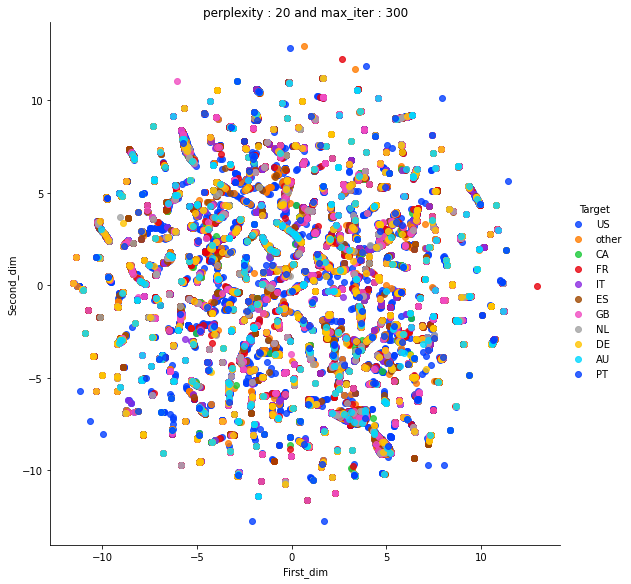

In [0]:
Tsne_visualization(X = Data, Y=Targets, perplexities =[20], itr=300)

* T-sne plot does not make sense for any key take aways from the analysis.   

**Conclusion:**
* The Data contain more number **Unknown** or **Null/Nan** values.
* The Dataset is slightly an **Imbalanced** amount class..
* The Dataset contains more no of **categorical variables** than numerical variables
* Great **Feature engineering** and Data **Pre-processing** is required to build sensible models.